Sometimes when reading in text from Japanese (or other) PDFs, the character encoding can't display every character.

```
落\n\n札\n\n落 札 者 等 の 公 示\n\n次のとおり落札者等について公示します。\n\n平成 31 年１月４日\n\n［掲載順序］\n\n①品目分類番号 ②調達件名及び数量 \ue7d3調達方法 \ue7d4契約方式 \ue7d5落札決定日（随意契約の場合\nは契約日） \ue7d6落札者（随意契約の場合は契約者）の氏名及び住所 \ue7d7落札価格（随意契約の場合\nは契約価格） \ue7d8入札公告日又は公示日 \ue7d9随意契約の場合はその理由 \ue7da指名業者名（指名競争\n入札の場合） \ue7bc落札方式 \ue7bd予定価格\n\n〇支出負担行為担当官 内閣府大臣官房会計担当参事官 横内 憲二 （東京都千代田区永田町１\ue61c\n\n６\ue61c１）\n\n◎調達機関番号 007
```

If you look at the PDF file, the text is an encoding called `UniJIS-UCS2-H`. I haven't heard of it, but it's something related to "ISO 10646-1:1993, UCS-2 encoding" [according to Adobe](https://www.adobe.com/content/dam/acom/en/devnet/font/pdfs/5094.CJK_CID.pdf). Maybe it has something to do with Shift-JIS, but decoding the characters doesn't ever seem to work.

**So let's learn to fix it.**

# Converting PDFs to text

This is Kenji's code! I just borrowed it.

In [15]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

def convert_pdf_to_txt(path): # 引数にはPDFファイルパスを指定
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    laparams.detect_vertical = True # Trueにすることで綺麗にテキストを抽出できる
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    maxpages = 0
    caching = True
    pagenos=set()
    fstr = ''
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,caching=caching, check_extractable=True):
        interpreter.process_page(page)

        str = retstr.getvalue()
        fstr += str

    fp.close()
    device.close()
    retstr.close()
    
    return fstr

## A function to replace 'bad' characters with the 'good' version

This function will replace bad characters with the good version. For example, the character `` cannot be displayed correctly, but it's really `①`! The bad character `` looks the same, but it's actually `②`.

The bad characters `` and `` look exactly the same, but they are secretly different because they have different codes:

|character|code|bad display|
|---|---|---|
|`①`|`\ue7d1`|``|
|`②`|`\ue7d2`|``|

If we know the codes, we can fix this problem. In the function below, I replace two of the bad characters with good versions.

In [3]:
def fix_characters(text):
    replacements = {
        '\ue7d1': '①',
        '\ue7d2': '②',
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

Let's test it out.

In [16]:
bad_text = "Go to the store\nBuy bread and milk"
good_text = fix_characters(bad_text)
good_text

'①Go to the store\n②Buy bread and milk'

Okay, cool, works well!

## Finding out the codes

But if every character looks the same, how do we know what code it is? It isn't _easy_, but it's possible!

First, we convert a PDF to text like we would normally. We'll also replace known bad characters with their good versions. Maybe some of the characters left are bad, right?

In [17]:
from io import StringIO

text = convert_pdf_to_txt("20190104c000010134.pdf")
text = fix_characters(text)

# Let's see the first 1000 characters
text[:1000]

'落\n\n札\n\n落 札 者 等 の 公 示\n\n次のとおり落札者等について公示します。\n\n平成 31 年１月４日\n\n［掲載順序］\n\n①品目分類番号 ②調達件名及び数量 \ue7d3調達方法 \ue7d4契約方式 \ue7d5落札決定日（随意契約の場合\nは契約日） \ue7d6落札者（随意契約の場合は契約者）の氏名及び住所 \ue7d7落札価格（随意契約の場合\nは契約価格） \ue7d8入札公告日又は公示日 \ue7d9随意契約の場合はその理由 \ue7da指名業者名（指名競争\n入札の場合） \ue7bc落札方式 \ue7bd予定価格\n\n〇支出負担行為担当官 内閣府大臣官房会計担当参事官 横内 憲二 （東京都千代田区永田町１\ue61c\n\n６\ue61c１）\n\n◎調達機関番号 007 ◎所在地番号 13\n\n①73 ②平成30年度国際広報キャンペーンテーマに係る広報の実施業務 広報テーマ：「我が国の\n平成30年度の戦略的メッセージの理解促進・浸透」（海外ＴＶ媒体・イベントを活用した発信事業）\n一式 \ue7d3購入等 \ue7d4随意 \ue7d530.11.30 \ue7d6㈱電通（東京都港区東新橋１\ue61c８\ue61c１） \ue7d792\uea75614\uea75320\n円 \ue7d9ｂ「排他的権利の保護」\n①73 ②平成30年度国際広報キャンペーンテーマに係る広報の実施業務 広報テーマ：「我が国の\n平成30年度の戦略的メッセージの理解促進・浸透」（国内英字媒体・オウンドメディアを活用した\n発信事業）一式 \ue7d3購入等 \ue7d4随意 \ue7d530.11.30 \ue7d6㈱電通（東京都港区東新橋１\ue61c８\ue61c１） \ue7d7\n8\n\uea75\n223\uea75271円 \ue7d9ｂ「排他的権利の保護」\n\n〇支出負担行為担当官 内閣府経済社会総合研究所次長 市川 正樹 （東京都千代田区永田町１\ue61c\n\n６\ue61c１）\n\n◎調達機関番号 007 ◎所在地番号 13\n\n①71、27 ②内閣府経済社会総合研究所システム運用管理業務 一式 \ue7d3購入等 \ue7d4一般 \ue7d5\n30. 9. 7 \ue7d6富士通株式会社（東京都

Now we make a dataframe of every single character on the page, and also its code.

In [12]:
import pandas as pd

# I want to see up to 500 rows
pd.set_option("display.max_rows", 500)

# Convert into a list of unique characters
# '田町1-6-1)' becomes ['田', '町', '1', '-', '6']
uniques = list(set(text))

# Make a dataframe of every character on the page
# List the 'code point' - the number that represents the character
# For example, 私 is 31169 - https://unicodemap.org/details/0x79C1/index.html
# The code point can be in decimal (0-9) or hex (0-9 + a-f)
codepoints = pd.DataFrame({
    'character': uniques,
    'decimal_code': [ord(char) for char in uniques],
    'hex_code': [hex(ord(char)).replace("0x", "\\u") for char in uniques]
})
codepoints

,character,decimal_code,hex_code
0,本,26412,\u672c
1,会,20250,\u4f1a
2,成,25104,\u6210
3,総,32207,\u7dcf
4,,59349,\ue7d5
5,ッ,12483,\u30c3
6,也,20063,\u4e5f
7,ブ,12502,\u30d6
8,埼,22524,\u57fc
9,高,39640,\u9ad8


You might recognize the `hex_code` column from our replacement function from earlier:

```python
def fix_characters(text):
    replacements = {
        '\ue7d1': '①',
        '\ue7d2': '②',
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text
```

When we do our replacing, we look for the hex code to replace with the good version.

### Finding the bad ones

Okay, we have all of our characters and all of their codes, but how do we find the bad ones? I only see a couple in there!

**I think only the codes above 50,000 are bad**, so let's only look at only those.

In [18]:
codepoints[codepoints.decimal_code > 50000]

,character,decimal_code,hex_code
4,,59349,\ue7d5
21,８,65304,\uff18
36,,59351,\ue7d7
51,）,65289,\uff09
56,（,65288,\uff08
68,,59354,\ue7da
86,１,65297,\uff11
97,３,65299,\uff13
102,,59324,\ue7bc
123,,60021,\uea75


Okay, so now we have a list of some codes that are bad. We just need to learn to convert them to 'good' characters.

### Finding what the 'good' version of the character is

Okay, number 364 is bad, the second-to-last one on the list. It's printed as ``, with decimal code `59353` and hex code `\ue7d9`.

Let's open our PDF and search for `` - we can't type the character, so we will cut and paste it.

When we search, it does not display correctly in the search box, but `⑨` is highlighted!

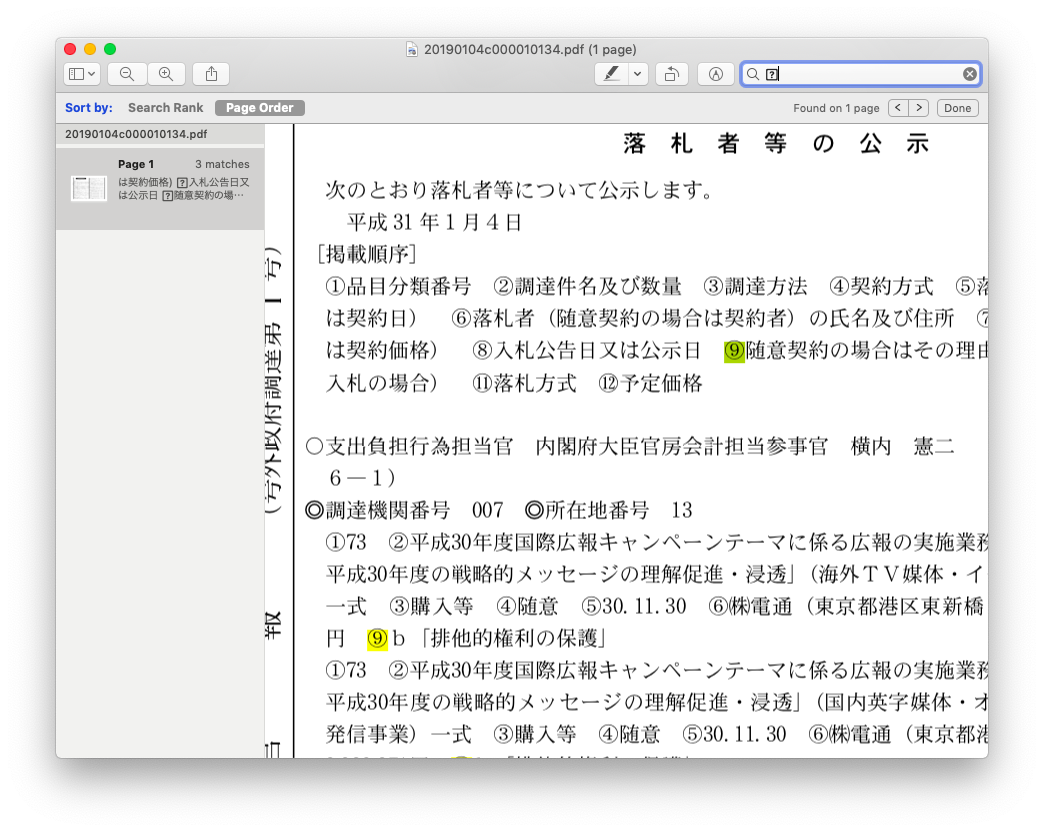

Now we will edit the `fix_characters` method to let it know that `\ue7d9` is `⑨`.

```python
def fix_characters(text):
    replacements = {
        '\ue7d1': '①',
        '\ue7d2': '②',
        '\ue7d9': '⑨'
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text
```

We will repeat this for **every missing character**. It won't be fun, but eventually we will have a function that can fix all of our bad characters!